In [69]:
import numpy as np
import pandas as pd
import datetime
import os.path
import sys
import backtrader as bt
import matplotlib.pyplot as plt
%matplotlib inline 

In [70]:
totlenBTC = pd.read_csv('totalLendsBTC.csv').drop(['Timestamp'],axis = 1)
totlenBTC = totlenBTC.rename(columns = {'Date':'datetime'})
hist_price = pd.read_csv("vwapHourlyBTCUSD.csv").drop(columns = ['Timestamp'])

In [71]:
totlenBTC['datetime'] = pd.to_datetime(totlenBTC['datetime'], infer_datetime_format = True).dt.floor('h')
hist_price['datetime'] = pd.to_datetime(hist_price['datetime'], infer_datetime_format = True).dt.ceil('h')

## Clean hist_price

In [72]:
hist_price.shape

(387760, 3)

In [73]:
hist_price = hist_price.sort_values('datetime')

In [74]:
hist_price = hist_price.drop(index = hist_price[hist_price['datetime'] <= '2000-01-01'].index)

In [75]:
anomal_val = hist_price['close'].iloc[0]

In [76]:
anomal_val

18670.66280423

In [77]:
hist_price = hist_price[(hist_price['close'] != anomal_val) | (hist_price['volume'] != 0)]

In [78]:
hist_price.shape

(44598, 3)

In [ ]:
hist_price.to_csv()

## Plot

In [79]:
hist_price = hist_price.merge(totlenBTC, on = 'datetime', how = 'left').dropna()
hist_price.index = range(hist_price.shape[0])

In [80]:
hist_price.head()

,datetime,close,volume,Avg Rate (%/day),Total Amount Active Swaps (BTC),Used,Unused
0,2013-04-02,103.1441,180.1005,0.03511,248.95,0.0,0.0
1,2013-04-03,117.3183,320.3558,0.03086,336.22,0.0,0.0
2,2013-04-04,128.7000,337.5020,0.01504,672.93,0.0,0.0
3,2013-04-05,132.6482,39.5852,0.02461,748.92,0.0,0.0
4,2013-04-06,142.5393,13.3100,0.02397,689.62,0.0,0.0


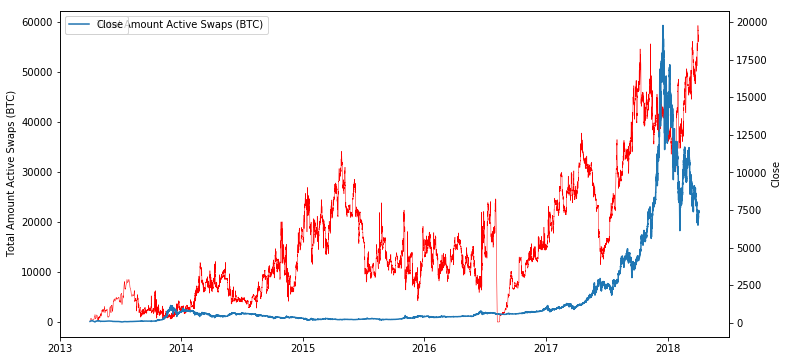

In [86]:
fig, ax = plt.subplots(figsize = (12,6))
ax.plot(hist_price['datetime'],hist_price['Total Amount Active Swaps (BTC)'],'r', linewidth = 0.5)
ax.set_ylabel('Total Amount Active Swaps (BTC)')
ax.legend(['Total Amount Active Swaps (BTC)'])
ax2 = ax.twinx()
ax2.plot(hist_price['datetime'],hist_price['close'])
ax2.set_ylabel('Close')
ax2.legend(['Close'])

## Margin Strat

In [87]:
for i in [1,5,10,15,30]:
    hist_price['ma_'+str(i)] = hist_price[['Total Amount Active Swaps (BTC)']].rolling(window = i).mean()

In [88]:
hist_price['position'] = np.NaN
hist_price['fund'] = np.NaN

In [89]:
hist_price['fund'].iloc[0] = 10000
hist_price['position'].iloc[0] = 0

D:\Software\Anaconda\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [90]:
hist_price['signal'] = np.NaN
for idx in hist_price.index:
    if idx < 30:
        continue
    #if hist_price.loc[idx, ['close','ma_5','ma_15']].notna().all():
    if hist_price.loc[idx, 'ma_5'] < hist_price.loc[idx, 'ma_30'] and \
    hist_price.loc[idx-1, 'ma_5'] > hist_price.loc[idx-1, 'ma_30']:
        hist_price.loc[idx,'signal'] = 1

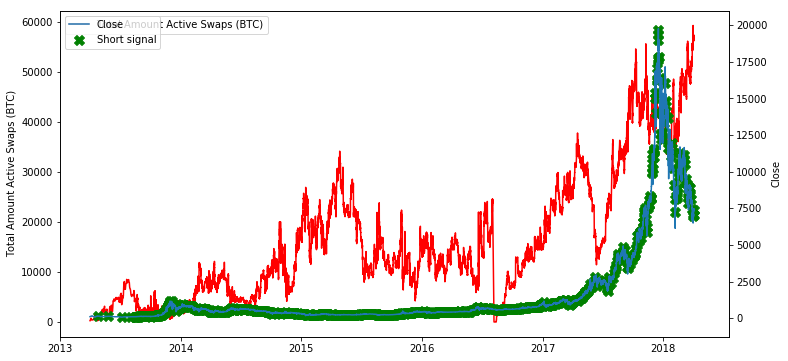

In [91]:
fig, ax = plt.subplots(figsize = (12,6))
ax.plot(hist_price['datetime'],hist_price['Total Amount Active Swaps (BTC)'],'r')
ax.set_ylabel('Total Amount Active Swaps (BTC)')
ax2 = ax.twinx()
ax2.plot(hist_price['datetime'],hist_price['close'])
ax2.scatter(hist_price.loc[hist_price['signal'] == 1,'datetime'].values,
            hist_price.loc[hist_price['signal'] == 1,'close'].values,
           marker = 'X', c = 'g', s = 100)
ax2.set_ylabel('Close')
ax.legend(['Total Amount Active Swaps (BTC)'])
ax2.legend(['Close','Short signal'])